![alt text](https://upload.wikimedia.org/wikipedia/en/9/97/Instituto_Tecnológico_de_Aeronáutica_%28logo%29.png "Logo Title Text 1")




# Trabalho Final de Cinemática e Dinâmica para Engenharia 



### Simulação dinâmica com massa variando axialmente ao longo de pêndulo invertido 

| Discente                            | e-mail          | 
| -------------------------------- | ----------- | 
| Guilherme Pereira Jorge Franze   | guipjfranze@gmail.com |       
                              
**Professor:** Domingos  Rade



O primeiro passo será definir todos os parâmetros utilizados nas simulações e também importar as bibliotecas necessárias para o teste.

In [144]:
# Importando bibliotecas necessárias
import os
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    figPath = os.getcwd()+os.sep+'Figs'+os.sep
    os.mkdir(figPath)
except:
    print("[INFO] Folder '{}' already exists.").format(figPath.split('/')[-2])

[INFO] Folder 'Figs' already exists.


In [197]:
# Definindo parâmetros iniciais
########################## PÊNDULO ##########################
# Parâmetros do pêndulo
comp_braco = 5.0   #Comprimento do braço do pêndulo [m]
mp = 5.5           #Massa do pêndulo [kg]
R = 0.1            #Raio do cilindro [m]
L = 0.3            #Comprimento do cilindro
c1 = 3.0           #Constante de atrito junta pêndulo-carro
g = 9.81           #Aceleração gravitacional
params_pend = [mp,R,L,c1,g]


########################## CARRO ###########################
# Parâmetros do carro
mc = 20.0   #Massa do pêndulo [kg]
c2 = 5.0  #Constante de atrito junta pêndulo-carro
hc = 0.4    #Altura do carro [m]
cc = 0.8    #Comprimento do carro [m]
params_carro = [mp+mc,c2,hc,cc]


##################### INTERVALO TEMPO ######################
# Criando intervalo de tempo para solução
tStop = 15.
tInc = 0.05
t = np.arange(0., tStop, tInc)

# Criando função de variação da posição do pêndulo no tempo
def r(t):
    PE = comp_braco/2  #Posição de equilíbrio (L/2)
    A = 1.0             #Amplitude de oscilação
    freq = 0.5            #Frequência de oscilação
    return PE+A*np.sin(2*np.pi*freq*t)

# Função para momento de inércia
def Jz(t, params=params_pend):
    mp,R,L,c1,g = params
    return (1./12)*mp*(3*R**2 + L**2) + mp*r(t)**2

# Criando uma força F de simuação que varia em função do 
# tempo ou pode ser constante
def F(t):
    A = 0.  #Amplitude de oscilação
    freq = 0.1 #Frequência de oscilação
    return A*np.sin(2*np.pi*freq*t)

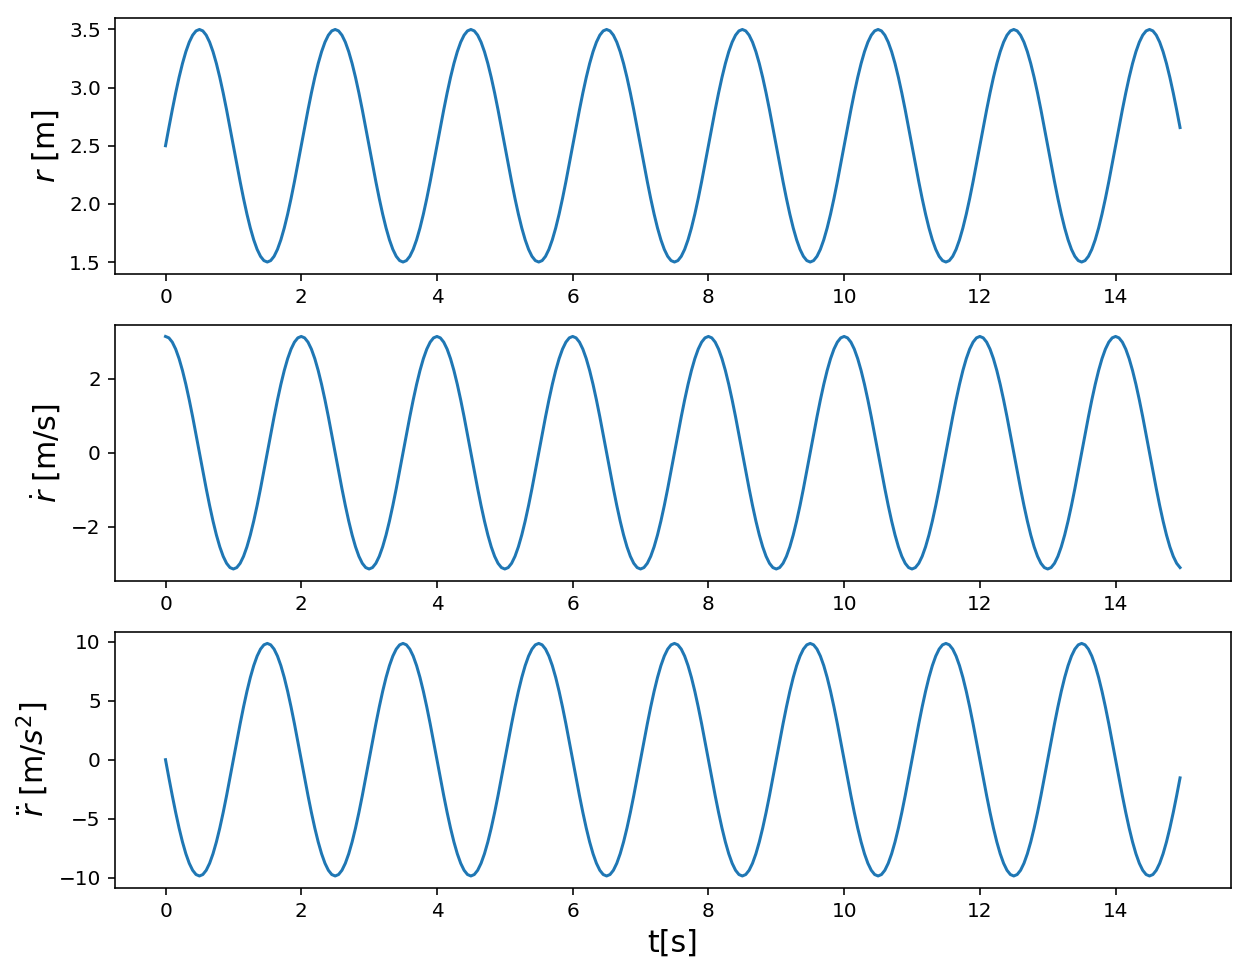

In [198]:
# Derivando r pra obter velocidade linear do pêndulo
d_r = nd.Derivative(r, n=1)
# Derivando d_r pra obter aceleração linear do pêndulo
dd_r = nd.Derivative(r, n=2)

# Criando figuras para exibição dos resultados
fig,ax = plt.subplots(3,1, figsize=(10,8))
fontsize=15

# Plotando posição da massa em função de tempo
ax[0].plot(t, r(t))
ax[0].set_ylabel('$r$ [m]',fontsize=fontsize)
# Plotando velocidade linear da massa em função de tempo
ax[1].plot(t, d_r(t))
ax[1].set_ylabel('$\\dot{r}$ [m/s]',fontsize=fontsize)
# Plotando aceleração linear da massa em função de tempo
ax[2].plot(t, dd_r(t))
ax[2].set_xlabel('t[s]',fontsize=fontsize)
ax[2].set_ylabel('$\\ddot{r}$ [m/$s^2$]',fontsize=fontsize)
plt.show()

# Equações de movimento do pêndulo simples 

## Equivalência entre conjunto de vetores que representam os esforços externos e as derivadas das quantidades de movimento linear e angular 

![alt text](Figs/Modelo.png "Title")

De acordo com a imagem, deduziu-se o modelo dinâmico do sistema.

$$ J_z(t) = J_{z{}'} + m_P * r(t)^2$$

$$ r(t) = P_E + A sin(2 \pi f t) $$


Através da igualdade dos momentos no ponto O, somatória de forças no eixo $x$ tanto para o carro como para o pêndulo, é possível deduzir as equações da derivada dos estados:

$$ \begin{bmatrix}
        \dot{\theta} \\ 
        \ddot{\theta} \\
        \dot{x}\\
        \ddot{x}
    \end{bmatrix} {}
	=
    \begin{bmatrix}
        \dot{\theta} \\ 
        \frac{1}{J_Z} \left [ m_P g r sin(\theta)- c_1 \dot{\theta} + \frac{h_c}{2} c_2 \dot{x}  \right ] \\ 
        \dot{x} \\ 
        - \frac{1}{m_T} \left \{ m_P \left [ r\ddot{\theta} cos(\theta)  + 2\dot{r}\dot{\theta}cos(\theta) - \ddot{r} sin(\theta) +  r \dot{\theta}^2 sin(\theta)  \right ] + F_{AT}   \right \} 
    \end{bmatrix} 
	+
    \begin{bmatrix}
        0 \\ 
        \frac{-h_c}{2 J_z(t)}\\ 
        0 \\ 
        \frac{1}{m_T}
    \end{bmatrix}F(t)
$$

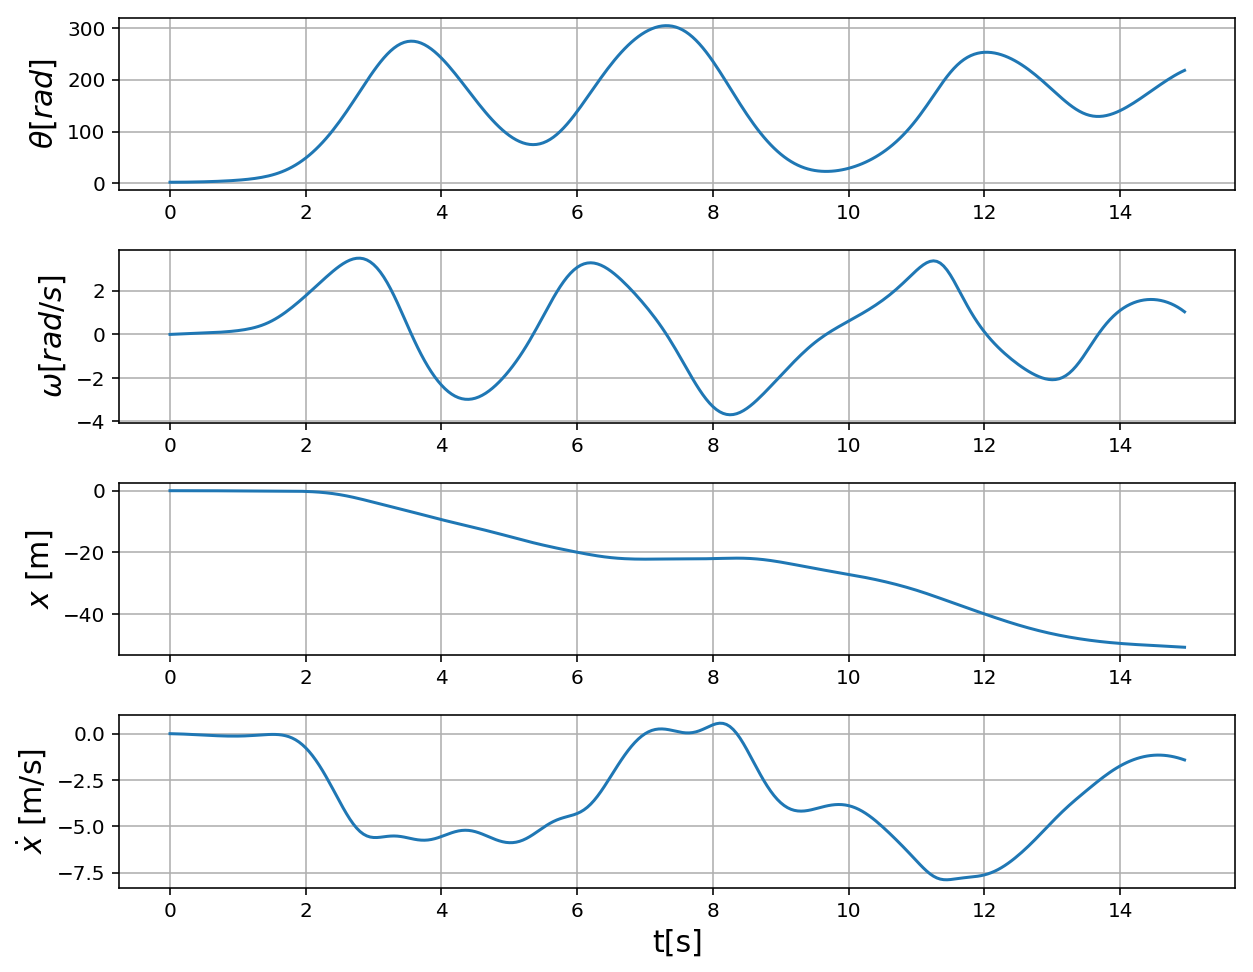

In [199]:
# Criando função do espaço de estados que será integrada
def pendulo_carro(X, t, paramsP, paramsC):
    theta, d_theta, x, d_x = X      #Descompactando valores de u
    mp,R,L,c1,g = paramsP           #Resgatando os parâmetros do pêndulo
    mt,c2,hc,cc = paramsC           #Resgatando os parâmetros do carro
    dd_theta = (1./Jz(t))*(mp*g*r(t)*np.sin(theta) - c1*d_theta - (hc/2.)*F(t) + (hc/2.)*c2*d_x)
    #Listando espaço de estados
    return [d_theta,        
            dd_theta,
            d_x,
            (1./(mt))*((F(t)) - (c2*d_x) - mp*(r(t)*dd_theta*np.cos(theta)+      
                                              2*d_r(t)*d_theta*np.cos(theta) - 
                                              dd_r(t)*np.sin(theta) +
                                              r(t)*d_theta**2*np.sin(theta)))]

# Definindo condições iniciais de integração
theta0, omega0, x0, v0 = np.deg2rad(2),0,0,0
x0 = [theta0, omega0, x0, v0]
# Executando integração
pcsoln = odeint(pendulo_carro, x0, t, args=(params_pend,params_carro,))


# Criando figuras para exibição dos resultados
fig,ax = plt.subplots(4,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.35)
fontsize=15
figName = "3SIM_MA.png"

# Plotando theta do pêndulo em função do tempo
ax[0].plot(t, np.rad2deg(pcsoln[:,0]))
ax[0].set_ylabel('$\\theta [rad]$',fontsize=fontsize)
ax[0].grid()
# Plotando omega do pêndulo em função do tempo
ax[1].plot(t, pcsoln[:,1])
ax[1].set_ylabel('$\\omega [rad/s]$',fontsize=fontsize)
ax[1].grid()
# Plotando velocidade do carro em função de tempo
ax[2].plot(t, pcsoln[:,2])
ax[2].set_ylabel('$x$ [m]',fontsize=fontsize)
ax[2].grid()
# Plotando aceleração do carro em função de tempo
ax[3].plot(t, pcsoln[:,3])
ax[3].set_xlabel('t[s]',fontsize=fontsize)
ax[3].set_ylabel('$\\dot{x}$ [m/s]',fontsize=fontsize)
ax[3].grid()
plt.show()

fig.savefig(figPath+figName,dpi=120)

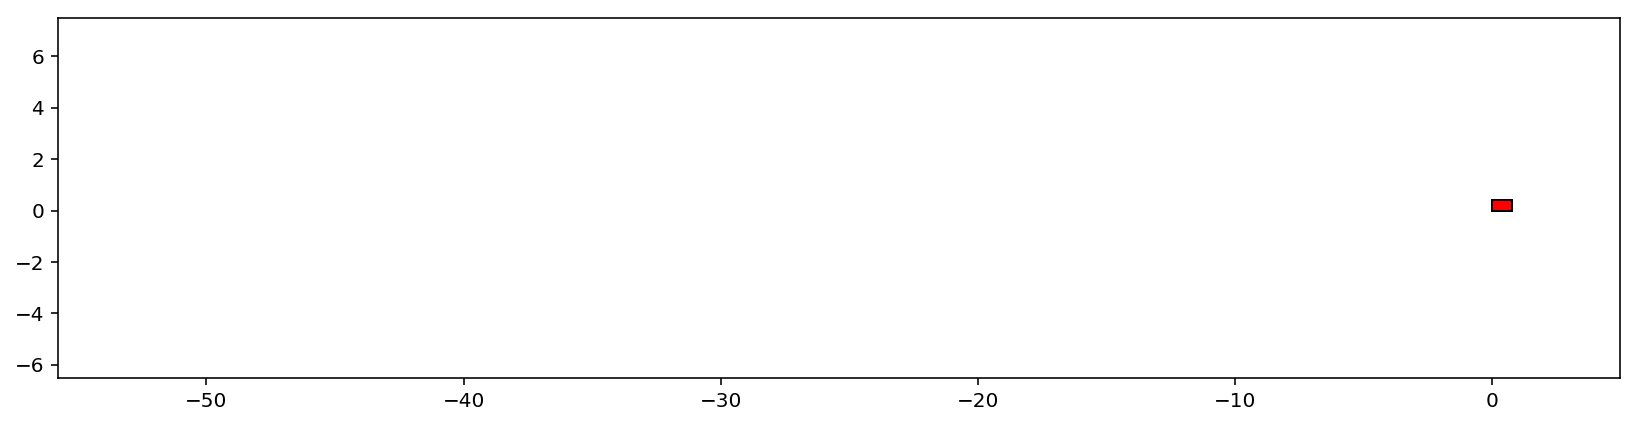

In [207]:
# Criando função para gerar animação da simulação dinâmica do sistema
def animate_pendulum(t,states,length,filename=None):
    # Primeiro, criando a figura, eixos e plotando elementos iniciais 
    # para animação
    fig = plt.figure(figsize=(14,8))
    # Configurando limites pela análise do movimento
    xmin = length*np.sin(states[:, 0]).min()+states[:, 2].min()
    xmax = length*np.sin(states[:, 0]).max()+states[:, 2].max()
    # Criando eixos
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-length-1.5, length+2.5), aspect='equal')
    # Exibindo tempo
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)
    # Gerando carro retangular
    rect = Rectangle([states[0, 2] - cc / 2.0, - hc / 2],
                     cc, hc, fill=True, color='red', ec='black')
    ax.add_patch(rect)
    # Linha branca para o pêndulo
    line, = ax.plot([],[], lw=2, marker='o', markersize=6)
    # Ponto branco para massa
    point, = ax.plot([],[], lw=2, marker='*', markersize=4, color="red")
    # Função inicializadora: plotando background para cada frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([],[])
        point.set_data([],[])
        return time_text, line, point,
    # Função de animação: atualização dos objetos
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 2] - cc / 2.0, - hc / 2))
        # Definindo coordenadas do pêndulos
        xp = np.hstack((states[i, 2], length*np.sin(states[i, 0])+states[i, 2]))
        yp = np.hstack((0,length*np.cos(states[i, 0])))
        line.set_data(xp, yp)
        # Definindo coordenadas da massa variante no pêndulo
        xm = length*np.sin(states[i, 0])/2. + (r(t[i])-length/2.)*np.sin(states[i, 0])
        ym = length*np.cos(states[i, 0])/2. + (r(t[i])-length/2.)*np.cos(states[i, 0])
        point.set_data(xm+states[i, 2],ym)
        return time_text, line, point,
    
    # Chamando a função de animação
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    # Salvar a animação se tiver nome de arquivo
    if filename is not None:
        anim.save(filename, fps=30, codec='libx264')
    return anim
        
anim = animate_pendulum(t, pcsoln, comp_braco)

In [208]:
# Mostrando video em HTML
HTML(anim.to_html5_video())

# Linearização simbólica do modelo para obtenção das matrizes do espaço de estados

As esquações que compõe o estado são não-lineares e precisam passar por um método de linearização.
Atualmente o sistema pode ser comparado à seguinte função multivaríavel:
$ \dot{x} = f(x,u) $

Sendo dada a condição de linearização, expande-se o vetor de funções $f(x,u)$ em torno de $x_0(t)$ e $u_0(t)$ usando a série de Taylor da seguinte forma:
$$
\dot{x_i}(t) = f(x_0(t),u_0(t))) + \left ( \frac{ \partial{f_i(x_0(t),u_0(t))}}{ \partial{x_1}}  \right )\delta x_1(t)+\cdots 
+
 \left ( \frac{ \partial{f_i(x_0(t),u_0(t))}}{ \partial{x_n}}  \right )\delta x_n(t) 
 +
\left ( \frac{ \partial{f_i(x_0(t),u_0(t))}}{ \partial{u_1}}  \right )\delta u_1(t) 
+ \cdots  +
\left ( \frac{ \partial{f_i(x_0(t),u_0(t))}}{ \partial{u_n}}  \right )\delta u_n(t) 
$$

Dessa forma, as matrizes $A$ e $B$ podem ser expressas como sendo:

$$A(t)= 
\begin{bmatrix}
\left (  \frac{\partial f_1}{\partial x_1} \right )_0 & \cdots  & \left (  \frac{\partial f_1}{\partial x_n} \right )_0 \\ 
\vdots  & \ddots   & \left (  \frac{\partial f_2}{\partial x_n} \right )_0 \\ 
\left (  \frac{\partial f_n}{\partial x_1} \right )_0 & \cdots  & \left (  \frac{\partial f_n}{\partial x_n} \right )_0
\end{bmatrix}_{(n \times n)}
$$

E,

$$
B(t)= 
\begin{bmatrix}
\left (  \frac{\partial f_1}{\partial u_1} \right )_0 & \cdots  & \left (  \frac{\partial f_1}{\partial u_m} \right )_0 \\ 
\vdots  & \ddots   & \left (  \frac{\partial f_2}{\partial u_m} \right )_0 \\ 
\left (  \frac{\partial f_n}{\partial u_1} \right )_0 & \cdots  & \left (  \frac{\partial f_n}{\partial u_m} \right )_0
\end{bmatrix}_{(n \times m)}
$$

O ponto de linearização escolhido foi:
$$
\begin{bmatrix}
\theta \\ 
\dot{\theta}\\ 
x\\ 
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 
0\\ 
0\\ 
0
\end{bmatrix}
\begin{bmatrix}
[deg] \\ 
[rad/s]\\ 
[m]\\ 
[m/s]
\end{bmatrix}
$$

E ainda, 
$$
\begin{bmatrix}
F 
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 
\end{bmatrix}
\begin{bmatrix}
N \\ 
\end{bmatrix}
$$

In [209]:
# Importando biblioteca de análise simbólica
from sympy import *

# Declarando variáveis simbólicas para parâmetros relacionados ao pêndulo e ao carro
f,mP,mT,C1,C2,j,G,HC = symbols("F m_P m_T c_1 c_2 J_z g h_c", real = True)     
# Declarando variáveis simbólicas para parâmetros relacionados ao angulo theta 
# do pêndulo com nosso plano de referência
T,dt,ddt = symbols("\\theta \\dot{\\theta} \\ddot{\\theta}", real = True)
# Declarando variáveis simbólicas para parâmetros relacionados à distância r 
# da massa do pêndulo com ponto O
R,DR,DDR = symbols("r \\dot{r} \\ddot{r}", real = True)     
# Declarando variáveis simbólicas para parâmetros relacionados ao deslocamento  
# do sistema todo
X,dx,ddx = symbols("x \\dot{x} \\ddot{x}", real = True)     

# Chamando método para exibição de símbolos em LaTeX
init_printing()

Estados:



Derivada dos Estados:



Equações das Derivada dos Estados:


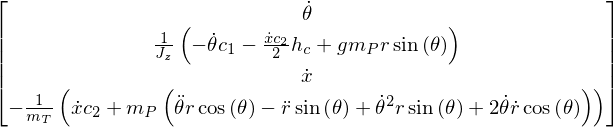


Termo forçante:


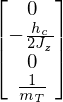

In [210]:
# Matriz dos estados
u = Matrix(([T],[dt],[X],[dx]))

# Matriz de Derivada dos estados
du = Matrix(([dt],[ddt],[dx],[ddx]))

# Matriz A não linearizada que compõe as equações das derivadas dos estados 
# e descreve o sistema
A_nLin = Matrix(([dt],
        [(1/j)*(mP*G*R*sin(T) - C1*dt - HC/2*(dx*C2))],
        [dx],
        [-(1/mT)*( mP*(R*ddt*cos(T)+2*DR*dt*cos(T)-DDR*sin(T)+R*dt**2*sin(T)) + C2*dx)]))  
# Matriz B de correlação das entradas com a dinâmica dos estados
B_lin = Matrix(([0], [-HC/(2*j)], [0], [1/mT]))

print("Estados:")
display(u)
print
print("Derivada dos Estados:")
display(du)
print
print("Equações das Derivada dos Estados:")
display(A_nLin)
print
print("Termo forçante:")
display(B_lin)

Matriz A simbólica:


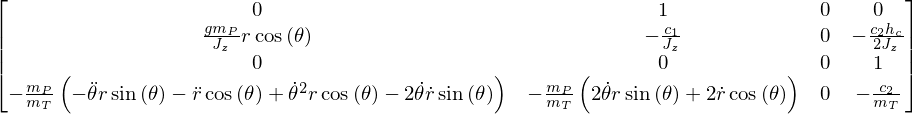


Matriz A:


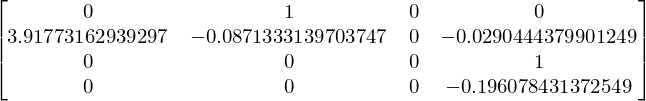


Matriz B:


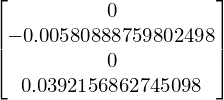

In [211]:
# Definindo função para calcular o gradiente simbólico
def gradient(scalar_function, variables):
    matrix_scalar_function = Matrix([scalar_function])
    return matrix_scalar_function.jacobian(variables)

# Calculando gradiente da função de derivadas de destados
A_lin = gradient(A_nLin,u)
print("Matriz A simbólica:")
display(A_lin)
print

# Valores iniciais de momento de inércia e distância r
J0 = Jz(0)
r0 = r(0)

# Definindo parâmetros do modelo estudado
parametros = ({mP:mp, mT:mp+mc, C1:c1, C2:c2, G:g, HC:hc, j:J0})

# Definindo condoções iniciais de linearização
cond_inic = ({T:0,dt:0,ddt:0,X:0,dx:0,ddx:0,R:r0,DR:0,DDR:0})

# Termos da substituição serão:
termos = dict(parametros.items() + cond_inic.items())

# Substituindo as condições iniciais e parâmetros para 
# obter as matrizes A e B do espaço de estados
NumA = A_lin.subs(termos)
NumB = B_lin.subs(termos)

print("Matriz A:")
display(NumA)
print
print("Matriz B:")
display(NumB)

# Convertendo as matrizes em float para efetuar as integrações
NumA = np.array(NumA).astype(np.float)
NumB = np.array(NumB).astype(np.float)

Com as matrizes linearizadas A e B é possível reescrever o espaço de estados da seguinte forma:

$$
\dot{x}(t) = A x(t) + X u
$$

# Regulagem de estados em malha fechada por alocação de polos

O sistema será regulado por meio do método de alocação de polos. Porém antes, é necessário avaliar o posto da matriz de controlabilidade para verificar se o sistema é completamente controlável.

In [212]:
from control import *
from numpy.linalg import matrix_rank

In [213]:
# Calculando posto da matriz de controlabilidade
print matrix_rank(ctrb(NumA, NumB)) 

4


Como o posto é o mesmo número de dimensões de A, pode-se afirmar que o sistema é controlável e é possível seguir adiante.

Em seguida, será avaliado a posição dos polos do sistema em malha aberta de forma a verificar sua estabilidade.

In [214]:
# Determinando os polos do sistema
polos = np.linalg.eig(np.array(NumA).astype(np.float))
print("Polos são: {}").format(polos[0])

Polos são: [ 1.93623881 -2.02337212  0.         -0.19607843]


Como alguns dos polos estão do lado positivo e real, pode-se concluir que o sistema é instável e necessita de uma alocação de polos para ser corrigido ao longo do tempo.

In [215]:
# Alocando polos nos reais [-1,-1,-1,-1]
K = place(NumA,NumB,[-1,-1,-1,-1])
print("Matriz de ganho é: {}").format(K[0])

Matriz de ganho é: [-1478.34860693  -702.36261191    -6.5088685     -9.26050888]


De forma a realimentar o sistema e reduzir o erro, é possível reescrever a equação de estados da seguinte forma:
$$
\dot{x}(t) = (A - B K) x(t) + X u
$$
sendo K, a matriz de ganhos obtidas com a alocação de polos.

Integrando essa equação da derivada dos estados, é possível obtê-los. A condição inicial considerada para a integração foi de:

$$
\begin{bmatrix}
\theta \\ 
\dot{\theta}\\ 
x\\ 
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
5 \\ 
0\\ 
0\\ 
0
\end{bmatrix}
\begin{bmatrix}
[deg] \\ 
[rad/s]\\ 
[m]\\ 
[m/s]
\end{bmatrix}
$$

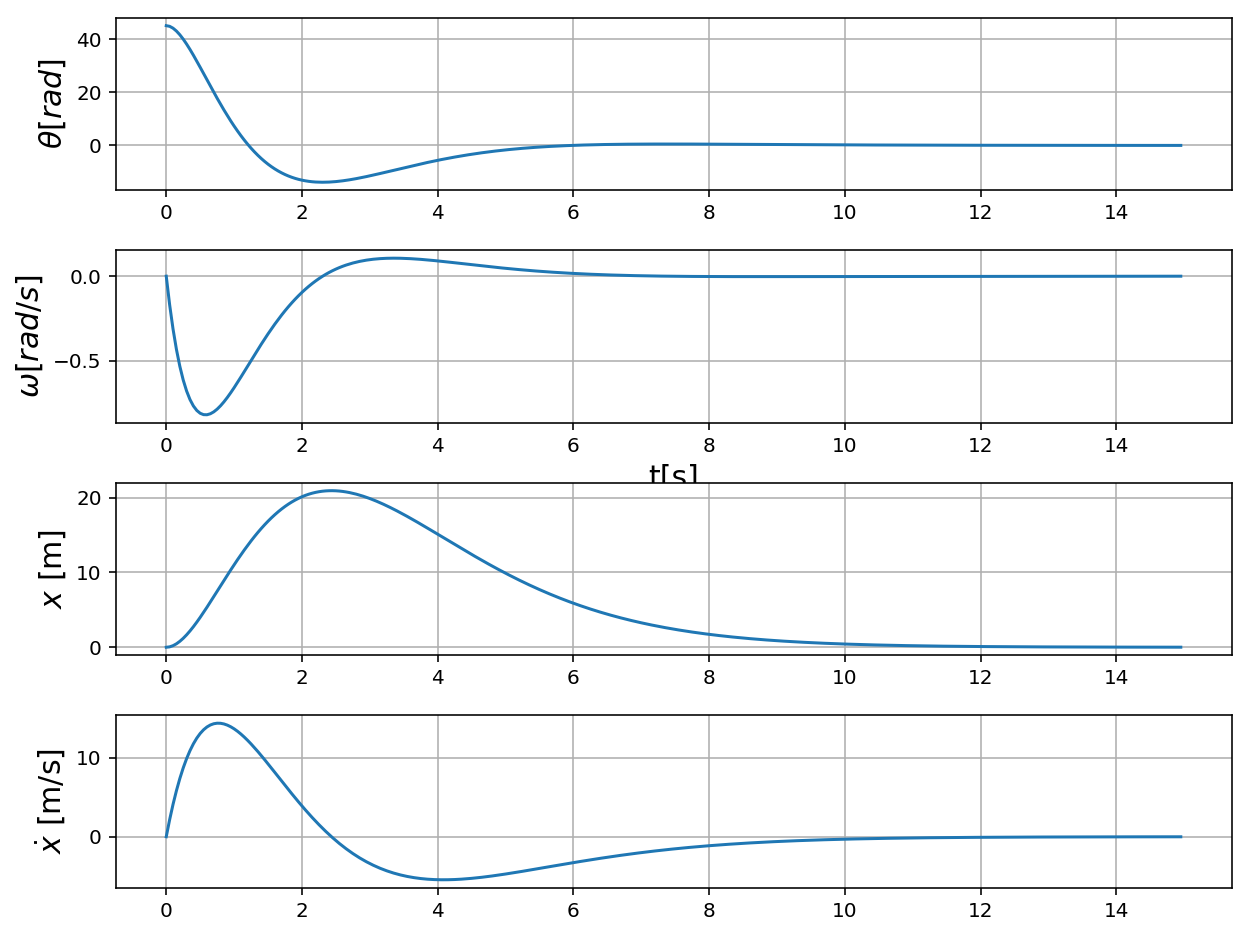

In [219]:
# Criando função do espaço de estados que será integrada
def controle_sistema(X, t, contr):
    return np.dot(contr, X)

# Definindo condições iniciais de integração
theta0, omega0, x0, v0 = np.deg2rad(45),0,0,0
x0 = [theta0, omega0, x0, v0]
# Executando integração
pcsol_malhaFechada = odeint(controle_sistema, x0, t, args=((NumA-NumB*K),))


# Criando figuras para exibição dos resultados
fig,ax = plt.subplots(4,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.35)
fontsize=15

# Plotando theta do pêndulo em função do tempo
ax[0].plot(t, np.rad2deg(pcsol_malhaFechada[:,0]))
ax[0].set_ylabel('$\\theta [rad]$',fontsize=fontsize)
ax[0].grid()
# Plotando omega do pêndulo em função do tempo
ax[1].plot(t, pcsol_malhaFechada[:,1])
ax[1].set_xlabel('t[s]',fontsize=fontsize)
ax[1].set_ylabel('$\\omega [rad/s]$',fontsize=fontsize)
ax[1].grid()
# Plotando velocidade do carro em função de tempo
ax[2].plot(t, pcsol_malhaFechada[:,2])
ax[2].set_ylabel('$x$ [m]',fontsize=fontsize)
ax[2].grid()
# Plotando aceleração do carro em função de tempo
ax[3].plot(t, pcsol_malhaFechada[:,3])
ax[3].set_ylabel('$\\dot{x}$ [m/s]',fontsize=fontsize)
ax[3].grid()
plt.show()

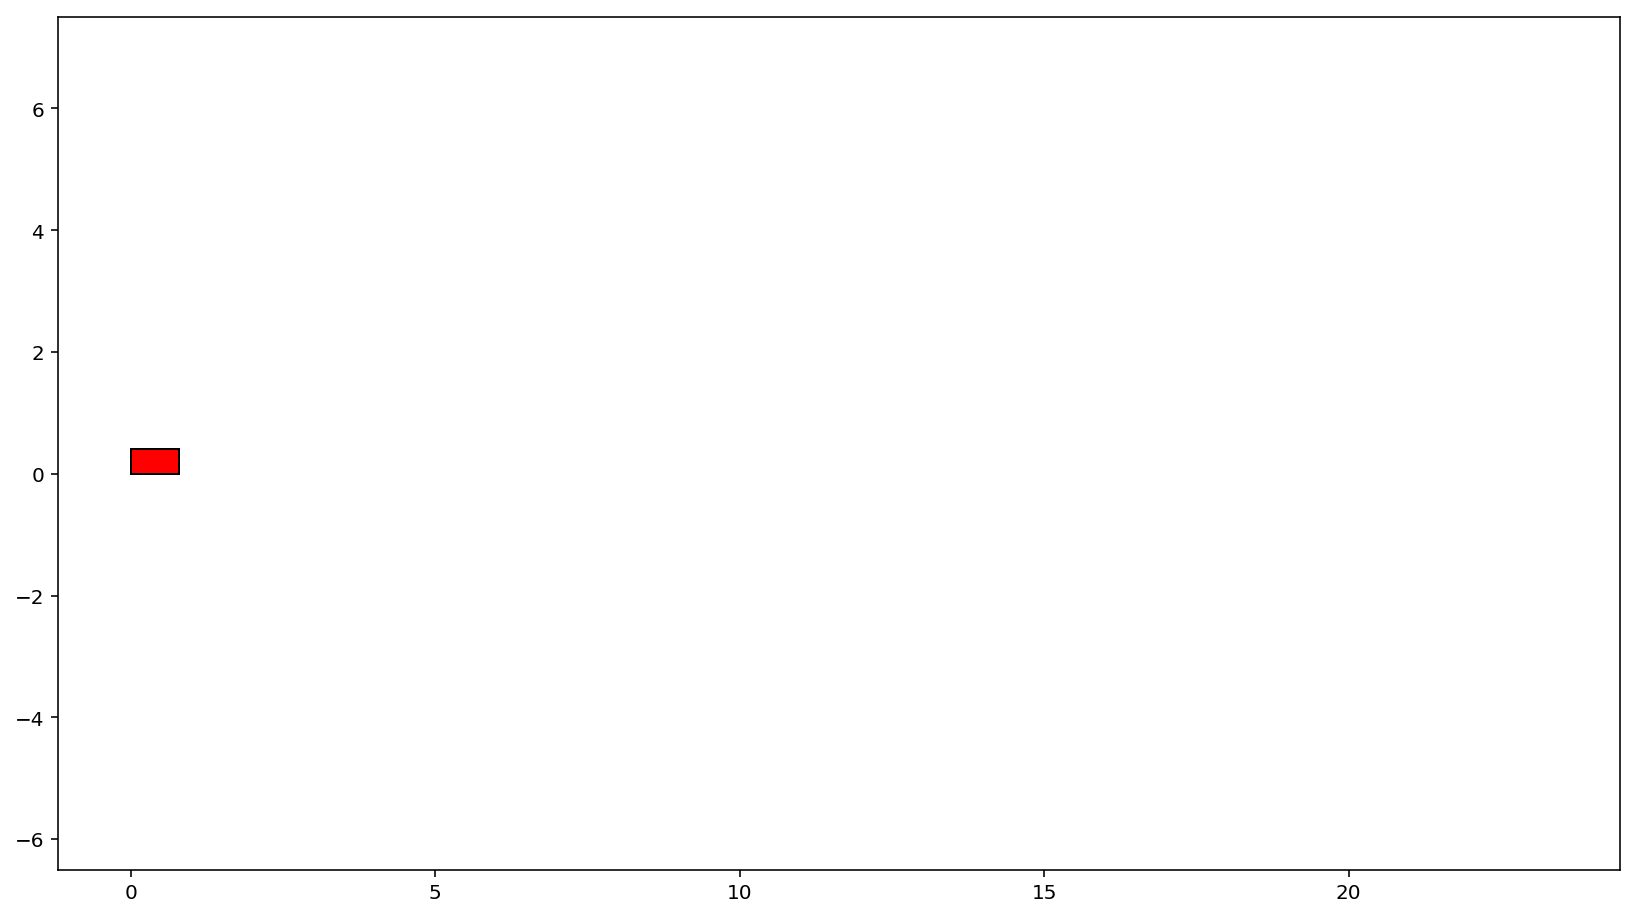

In [217]:
anim = animate_pendulum(t, pcsol_malhaFechada, comp_braco)

In [218]:
# Mostrando video em HTML
HTML(anim.to_html5_video())

[[ 0.          1.          0.          0.        ]
 [ 3.13618926 -0.89514066  0.         -0.25575448]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618926 -0.89514066  0.         -0.25575448]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618926 -0.89514066  0.         -0.25575448]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618926 -0.89514066  0.         -0.25575448]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618926 -0.89514066  0.         -0.25575448]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618869 -0.89514034  0.         -0.25575438]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618869 -0.89514034  0.         -0.25575438]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618839 -0.89514017  0.         -0.25575433]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618839 -0.89514017  0.         -0.25575433]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89514     0.         -0.25575429]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89514     0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89514     0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89514     0.         -0.25575428]
 [ 0.          0.         

[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618809 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.         

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618808 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618807 -0.89513999  0.         -0.25575428]
 [ 0.          0.         

[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513998  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618805 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.         

[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.         

 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.         

[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.         -0.24390244]]
[[ 0.          1.          0.          0.        ]
 [ 3.13618804 -0.89513997  0.         -0.25575428]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          

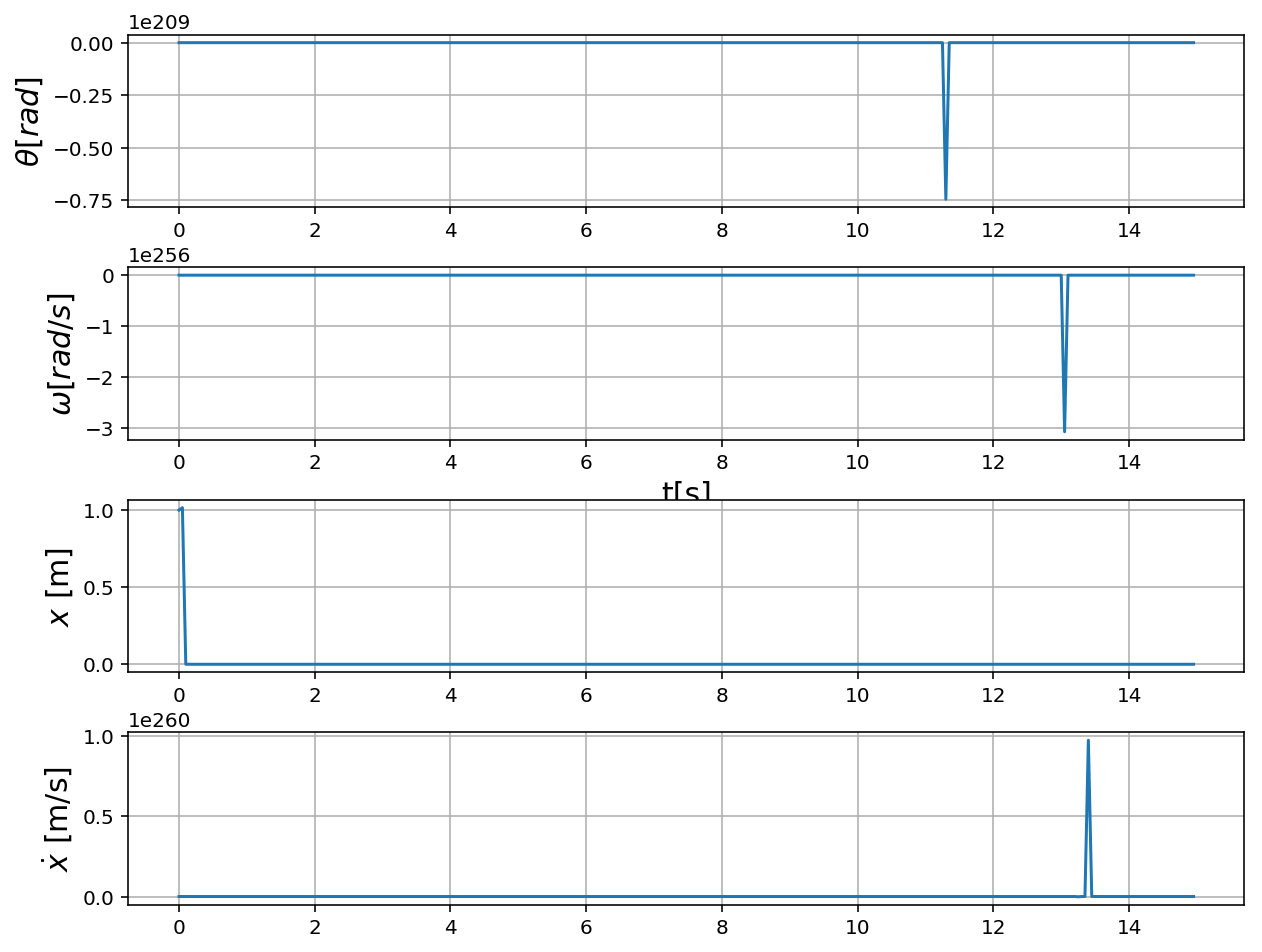

In [196]:
# Definindo parâmetros iniciais
########################## PÊNDULO ##########################
# Parâmetros do pêndulo
mp = 0.5           #Massa do pêndulo [kg]
c1 = 3.5           #Constante de atrito junta pêndulo-carro
params_pend = [mp,R,L,c1,g]

# Criando função de variação da posição do pêndulo no tempo
def r(t):
    PE = comp_braco/2  #Posição de equilíbrio (L/2)
    A = 0.001             #Amplitude de oscilação
    freq = 0.01            #Frequência de oscilação
    return PE+A*np.sin(2*np.pi*freq*t)

# Função para momento de inércia
def Jz(t, params=params_pend):
    mp,R,L,c1,g = params
    return (1./12)*mp*(3*R**2 + L**2) + mp*r(t)**2

def controle_sistema_atualizacao(XX, t, A_lin, B_lin):
    theta, d_theta, x, d_x = XX       #Descompactando valores de u
    # Valores atualizados de momento de inércia e distância r
    J_init = Jz(t)
    r_init = r(t)
    # Atualizando parâmetros do modelo estudado
    parametros = {mP:mp, mT:(mp+mc), C1:c1, C2:c2, G:g, HC:hc, j:J_init}
    # Definindo condoções iniciais de linearização já adotadas
    cond_inic = {T:0, dt:0, ddt:0,
                 X:0, dx:0, ddx:0,
                 R:r_init, DR:0, DDR:0}
    # Agrupando termos para substituição global
    termos = dict(parametros.items() + cond_inic.items())
    # Substituindo as condições iniciais e parâmetros atualizados  
    # para obter a atualização das matrizes A e B do espaço de estados
    NumA = np.array(A_lin.subs(termos)).astype(np.float64)
    NumB = np.array(B_lin.subs(termos)).astype(np.float64)
    print NumA
        
    # Calculando novos valores de ganhos para correção
    K = place(NumA,NumB,[-1.2,-1.2,-1.2,-1.2])
    
    # Calculando novos valores de ganhos para equação equivalente do
    # processo de realimentação de estados.
    contr = (NumA-NumB*K)
    
    return [np.dot(contr[0], XX),
            np.dot(contr[1], XX),
            np.dot(contr[2], XX),
            np.dot(contr[3], XX)]

# Definindo condições iniciais de integração
theta0, omega0, x0, v0 = np.deg2rad(2),0,1,1
x0 = [theta0, omega0, x0, v0]
# Executando integração
pcsol_malhaFechada_atualizacao = odeint(controle_sistema_atualizacao, x0, t, args=(A_lin,B_lin,))


# Criando figuras para exibição dos resultados
fig,ax = plt.subplots(4,1, figsize=(10,8))
fig.subplots_adjust(hspace=0.35)
fontsize=15

# Plotando theta do pêndulo em função do tempo
ax[0].plot(t, pcsol_malhaFechada_atualizacao[:,0])
ax[0].set_ylabel('$\\theta [rad]$',fontsize=fontsize)
ax[0].grid()
# Plotando omega do pêndulo em função do tempo
ax[1].plot(t, pcsol_malhaFechada_atualizacao[:,1])
ax[1].set_xlabel('t[s]',fontsize=fontsize)
ax[1].set_ylabel('$\\omega [rad/s]$',fontsize=fontsize)
ax[1].grid()
# Plotando velocidade do carro em função de tempo
ax[2].plot(t, pcsol_malhaFechada_atualizacao[:,2])
ax[2].set_ylabel('$x$ [m]',fontsize=fontsize)
ax[2].grid()
# Plotando aceleração do carro em função de tempo
ax[3].plot(t, pcsol_malhaFechada_atualizacao[:,3])
ax[3].set_ylabel('$\\dot{x}$ [m/s]',fontsize=fontsize)
ax[3].grid()
plt.show()

/Users/guipjfranze/anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/guipjfranze/anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


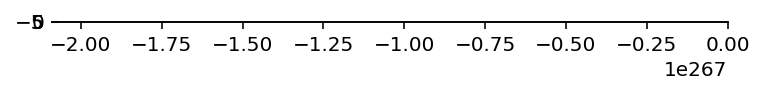

In [194]:
anim = animate_pendulum(t, pcsol_malhaFechada_atualizacao, comp_braco)

In [195]:
# Mostrando video em HTML
HTML(anim.to_html5_video())